# Bear Keypoint Detection

This Jupyter notebook trains a model to detect several keypoints on bear heads.  As of this writing, it's looking at the eye and the nasal lateral commissure.  It requires a dataset.  You can generate the files by using Darwin, and going to Settings -> Developer Tools -> Export Training Dataset.  (The keypoints already need to be properly placed in Darwin for this to work -- we're training the network to find similar locations to what's in the Darwin data.)  This creates a CSV file with a list of images and coordinates, as well as an images folder with cropped bear heads.  You need to copy both to the same directory as this notebook.

The notebook assumes you're using Keras on Tensorflow.  It also makes use of Albumentations.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
from time import sleep
import os

image_dim = 224
rescale_coordinates = False
preprocessing_needed = False
grayscale = False
image_directory = 'images'
dataframe = pd.read_csv('darwin_coordinates.csv')

data = dataframe.values

print(data)

[['000001.jpg' 84.55475 95.43130500000001 177.05202 173.47653]
 ['000002.jpg' 107.07425 98.75328 191.56851 175.6071]
 ['000003.jpg' 96.69281 95.67463000000001 183.59224 174.5833]
 ...
 ['000241.jpg' 109.64168000000001 101.566025 177.7512 176.72137]
 ['000242.jpg' 119.2274 99.58266 195.37003 177.1627]
 ['000243.jpg' 133.79124 107.59344499999999 195.40884 180.12778]]


The functions below rescale the coordinates.  They're not currently being used, but were a try to normalize data a little and help the model converge.

In [2]:
# Rescale the coordinates to between -1 and 1
# The point of this is to help the model converge during training
def rescale_coordinates_down(coordinates):
    half_image_dim = image_dim / 2
    coordinates = (coordinates - half_image_dim) / half_image_dim
    return coordinates
    
# Rescale the coordinates back to their original values
def rescale_coordinates_up(coordinates):
    half_image_dim = image_dim / 2
    coordinates = coordinates * half_image_dim + half_image_dim
    return coordinates

## Display Dataset Examples

Display a random selection of the images and the keypoints from the dataset to verify we have loaded everything correctly.

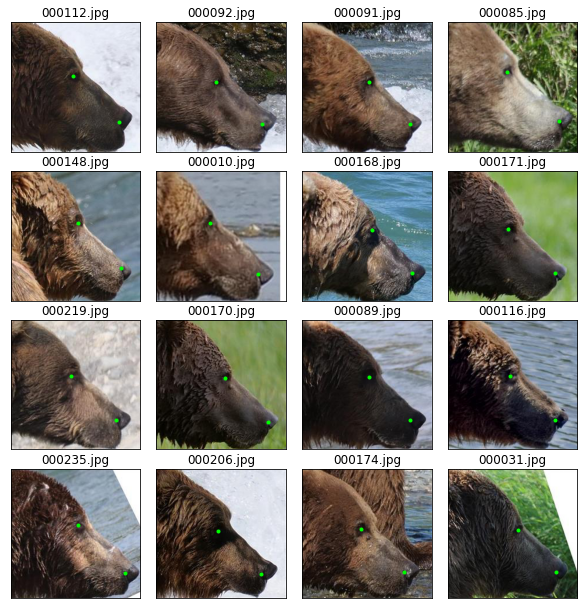

In [3]:
import cv2

def plot_pts(img_filename, pts):
    full_filename = os.path.join(image_directory, img_filename)
    image = cv2.imread(full_filename)
    #image = cv2.resize(image, (image_dim, image_dim), interpolation = cv2.INTER_CUBIC)
    
    if grayscale == True:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        plt.imshow(image, cmap='gray')
    else:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        
    
    for i in range(1, pts.shape[0], 2):
        plt.plot(pts[i-1], pts[i], marker='.', color='#00FF00')

        #plt.plot(pts[i-1] * image_half_width + image_half_width, pts[i] * image_half_height + image_half_height, 'c.')
        #plt.plot(exp[i-1], exp[i], 'g.')
        
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.15, wspace=0.05)
num_display_images = 16

ax = type('', (), {})()
for i in range(num_display_images):
    irandom_pic = np.random.choice(data.shape[0])
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_pts(data[irandom_pic][0], data[irandom_pic][1:])
    ax.set_title(data[irandom_pic][0])
plt.show()

## Model Creation Functions

A couple functions to create different models.  There are a couple tries below.

For some of the transfer learning models, we sometimes try to freeze the model (i.e., make the transfer part trainable = False), do some initial training to get the final layers more stable, unfreeze the model, then train it more.

In [4]:
from tensorflow.keras.applications import ResNet50V2
#from tensorflow.keras.applications import MobileNetV2

# If using transfer learning, the import for preprocess_input needs to be for the corresponding model
# being used
from tensorflow.keras.applications.resnet_v2 import preprocess_input
#from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from tensorflow.keras.models import Sequential, Model, save_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, LeakyReLU, Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D

# Returns model with the resnet piece initially untrainable
def create_resnetv2_model(num_outputs = 4):
    #image_input = Input(shape=(image_dim,image_dim,3))
    global preprocessing_needed
    preprocessing_needed = True
    conv_base = ResNet50V2(input_shape=(image_dim,image_dim,3), include_top=False, weights='imagenet')
    
    for layer in conv_base.layers[:-1]:
        layer.trainable = False

    #custom_resnet_model.layers[-1].trainable
    
    model = Sequential()
    model.add(conv_base)
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(num_outputs))
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model

def create_mobilenetv2_model(num_outputs = 4):
    #image_input = Input(shape=(image_dim,image_dim,3))
    global preprocessing_needed
    preprocessing_needed = True
    conv_base = MobileNetV2(input_shape=(image_dim,image_dim,3), include_top=False, pooling=None, weights='imagenet')
    
    #for layer in custom_resnet_model.layers[:-1]:
    #    layer.trainable = False

    #custom_resnet_model.layers[-1].trainable
    
    model = Sequential()
    model.add(conv_base)
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(num_outputs))
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return model

def create_resnet_model(num_outputs = 4):
    #image_input = Input(shape=(image_dim,image_dim,3))
    global preprocessing_needed
    preprocessing_needed = True
    conv_base = ResNet50(input_shape=(image_dim,image_dim,3), include_top=False, weights='imagenet')
    #for layer in custom_resnet_model.layers[:-1]:
    #    layer.trainable = False

    #custom_resnet_model.layers[-1].trainable
    
    model = Sequential()
    model.add(conv_base)
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(num_outputs))
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    #model.summary()
    
    return model

def create_basic_model(num_outputs = 4):
    global preprocessing_needed
    preprocessing_needed = False
    
    model = Sequential()

    model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(image_dim,image_dim,3)))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())

    model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())

    model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())

    model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())

    model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())

    model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())

    model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(num_outputs))

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    #model.summary()
    
    return model

def create_model(num_outputs=4, color_channels=3):
    global preprocessing_needed
    preprocessing_needed = False
    
    model = Sequential()

    model.add(Convolution2D(74, (3,3), padding='same', use_bias=False, input_shape=(image_dim,image_dim,color_channels)))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())

    model.add(Convolution2D(74, (3,3), padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())

    model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())

    model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())

    model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())

    model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())

    model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(num_outputs))

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    #model.summary()
    
    return model

## Create the Model

Use one of the functions above to create a model.

In [5]:
#model = create_resnetv2_model(num_outputs = data.shape[1] - 1)
model = create_resnetv2_model(num_outputs = data.shape[1] - 1)
#model = create_model(num_outputs = data.shape[1] - 1, color_channels=3)

# Set up callbacks for learning rate reduction and early stop
LR_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=10, factor=.4, min_lr=.00001)
EarlyStop_callback = tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               51380736  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 2052      
Total params: 74,947,588
Trainable params: 51,382,788
Non-trainable params: 23,564,800
_________________________________________________________________


## Create Generators

We could load the whole dataset into memory, but we're also using augmentation, and my computer runs out of memory doing this.
So below are generators that will load portions of the dataset at a time to save memory.  The ValidationGenerator is for validation, and 
AugmentedImageGenerator also has a call to augment the x/image data.  Note that both of these also have preprocess_input function callbacks
that are called on image data if they're passed.  These are necessary to get the model to work if using an existing model and doing transfer learning
(e.g. if you use resnet).

In [6]:
import albumentations as A
import cv2

class ValidationGenerator(tf.keras.utils.Sequence):
    'Keras generator'
    def __init__(self, data, preprocess_input=None, batch_size=64, shuffle=True):
        'Initialization'
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.preprocess_input = preprocess_input

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.data.shape[0] / self.batch_size))

    def on_epoch_end(self):
        self.indexes = np.arange(self.data.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        x, y = self.__data_generation(indexes)

        if self.preprocess_input is not None:
            x = self.preprocess_input(x.astype(np.uint8))
        else:
            x = x.astype(np.float32) / 255
            
        if rescale_coordinates == True:
            return x, rescale_coordinates_down(y)
        else:
            return x, y

    def __data_generation(self, indexes):
        X = np.empty((self.batch_size, image_dim, image_dim, 3))
        
        if grayscale == True:
            X = np.empty((self.batch_size, image_dim, image_dim, 1))
        
        y = np.empty((self.batch_size, self.data.shape[1] - 1))
        
        for i in range(len(indexes)):
            full_filename = os.path.join(image_directory, self.data[indexes[i]][0])
            image = cv2.imread(full_filename)
            if grayscale == True:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).reshape(image_dim,image_dim,1)
            else:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            X[i] = image
            y[i] = self.data[indexes[i]][1:]

        return X.astype(np.uint8), y.astype(np.float32)

class AugmentedImageGenerator(tf.keras.utils.Sequence):
    'Keras generator'
    def __init__(self, data, augmentations, preprocess_input=None, batch_size=64, flip=True, shuffle=True):
        'Initialization'
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.flip = flip
        self.preprocess_input = preprocess_input
        self.augmentations = augmentations
        
        #self.flip_indices = [
        #        (0, 2), (1, 3),
        #        (4, 8), (5, 9), (6, 10), (7, 11),
        #        (12, 16), (13, 17), (14, 18), (15, 19),
        #        (22, 24), (23, 25)
        #        ]
        
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.data.shape[0] / self.batch_size))

    def on_epoch_end(self):
        self.indexes = np.arange(self.data.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        'Generate one batch of data'

        indexes = self.indexes[index * self.batch_size:(index+1) * self.batch_size]

        # Generate data
        x, y = self.__data_generation(indexes)

        # We have a separate flip method because some of the labels need to be changed
        # when we flip horizontally.  E.g. the left eye becomes the right and vice versa.
        # Albumentations can't currently handle that
        if len(indexes) > 1 and self.flip == True:
            x, y = self.__flip(x, y)

        # Reshape the labels so they match the xy keypoint shape Albumentations expects
        y_augment = y.reshape(y.shape[0], int(y.shape[1] / 2), 2)

        # Albumentations doesn't like float64
        # Need the line for x if we're dividing the image by 255
        #x = x.astype(np.float32)
        y_augment = y_augment.astype(np.float32)

        for i in range(x.shape[0]):
            transformed = self.augmentations(image=x[i], keypoints=y_augment[i])
            x[i] = transformed['image']
            y_augment[i] = np.asarray(transformed['keypoints'], dtype=np.float32)

        if self.preprocess_input is not None:
            x = self.preprocess_input(x.astype(np.uint8))
        else:
            x = x.astype(np.float32) / 255
            
        if rescale_coordinates == True:
            return x, rescale_coordinates_down(y_augment.reshape(y.shape[0], y.shape[1]))
        else:
            return x, y_augment.reshape(y.shape[0], y.shape[1])

    def __data_generation(self, indexes):
        X = np.empty((self.batch_size, image_dim, image_dim, 3))
        
        if grayscale == True:
            X = np.empty((self.batch_size, image_dim, image_dim, 1))
        
        y = np.empty((self.batch_size, self.data.shape[1] - 1))
        
        for i in range(len(indexes)):
            full_filename = os.path.join(image_directory, self.data[indexes[i]][0])
            image = cv2.imread(full_filename)
            if grayscale == True:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).reshape(image_dim,image_dim,1)
            else:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            X[i] = image
            y[i] = self.data[indexes[i]][1:]

        return X.astype(np.uint8), y.astype(np.float32)
    
    # Flip code is adapted from Yumi's code at:
    # https://fairyonice.github.io/achieving-top-23-in-kaggles-facial-keypoints-detection-with-keras-tensorflow.html
    def __flip(self, x_batch, y_batch, prop = 0.5):
        batch_size = x_batch.shape[0]
        indices = np.random.choice(batch_size, int(batch_size * prop), replace=False)

        x_batch[indices] = x_batch[indices, :, ::-1,:]
        
        # Opencv version of flipping the image
        #for i in range(batch_size):
        #    x_batch[i] = cv2.flip(x_batch[i], 1).reshape(400,400,1)
        
        if rescale_coordinates == True:
            y_batch[indices, ::2] = y_batch[indices, ::2] * -1
        else:
            y_batch[indices, ::2] = y_batch[indices, ::2] - image_dim
            y_batch[indices, ::2] = np.abs(y_batch[indices, ::2])
            
        # If there is a rescale on the coordinates

        # Flip left eye to right eye, left mouth to right mouth and so on .. 
        #for a, b in self.flip_indices:
        #    y_batch[indices, a], y_batch[indices, b] = (
        #            y_batch[indices, b], y_batch[indices, a]
        #        )
        return x_batch, y_batch

## Train the model

Now train the model.  This also holds back a percentage of the records for validation.  It also sets up a data augmentation transform to create some extra data out of the images/keypoints.  The augmentation is using [Albumentations](https://github.com/albumentations-team/albumentations)

In [7]:
# Split our training dataset into training and validation
validation_percentage = 0.1
num_validation = int(round(validation_percentage * data.shape[0]))

# Before we actually split it, shuffle so we're picking random samples for each train/validation
np.random.shuffle(data)

validation_data, train_data = data[:num_validation,:], data[num_validation:, :]

# Set up our data augmentation transforms
transform = A.Compose([
    A.RandomContrast(limit=0.2, p=0.2),
    A.RandomGamma(gamma_limit=(80, 120), p=0.2),
    A.ShiftScaleRotate(scale_limit=0.1,rotate_limit=15,p=0.3),
    A.RandomBrightness(limit=0.2, p=0.2),
    A.Blur(p=0.1),
    A.GaussNoise(var_limit=(10.0, 50.0), mean=0, always_apply=False, p=0.25)
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

# The preprocess_input lines are needed if using an existing model like resnet50 and
# doing transfer learning.
if preprocessing_needed == True:
    preprocess_function = preprocess_input
else:
    preprocess_function = None

generator = AugmentedImageGenerator(data=train_data,
                                    preprocess_input=preprocess_function,
                                    augmentations=transform,
                                    flip=True,
                                    batch_size=32)

validation_generator = ValidationGenerator(data=validation_data,
                                           preprocess_input=preprocess_function,
                                           batch_size=num_validation # Setting the validation to the whole validation set.  Might need to adjust if run
                                                                    # on a larger dataset. (E.g. if this runs out of memory)
                                          )

history = model.fit_generator(
                                generator=generator,
                                validation_data=validation_generator,
                                epochs=100,
                                validation_steps=1 # We set the batch_size to the whole validation set above, so just one validation step
                             )

## Unfreeze and Continue Training

Optional based on the model we created above.  But if we created one that's frozen for the prebuilt model (i.e. layers trainable = False), then unfreeze all the layers and train more while also adjusting the learning rate a bit.

In [ ]:
# Make all the layers trainable
for layer in model.layers[:-1]:
    layer.trainable = True
    
# Recompile to apply the layer trainability change
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Update the learning rate
print("Current learning rate:", model.optimizer.learning_rate.numpy())

model.optimizer.learning_rate.assign(0.0001)

print("Updated learning rate:", model.optimizer.learning_rate.numpy())

In [30]:
# Train more
history = model.fit_generator(
                                generator=generator,
                                validation_data=validation_generator,
                                epochs=10,
                                validation_steps=1 # We set the batch_size to the whole validation set above, so just one validation step
                             )

Epoch 1/10
6/6 [==============================] - 42s 7s/step - loss: 28.0452 - mean_absolute_error: 4.1077 - val_loss: 2.3185 - val_mean_absolute_error: 1.2649
Epoch 2/10
6/6 [==============================] - 41s 7s/step - loss: 27.2200 - mean_absolute_error: 4.1358 - val_loss: 2.2836 - val_mean_absolute_error: 1.2433
Epoch 3/10
6/6 [==============================] - 41s 7s/step - loss: 28.3691 - mean_absolute_error: 4.2687 - val_loss: 2.9407 - val_mean_absolute_error: 1.3595
Epoch 4/10
6/6 [==============================] - 47s 8s/step - loss: 31.6282 - mean_absolute_error: 4.3585 - val_loss: 3.1828 - val_mean_absolute_error: 1.4189
Epoch 5/10
6/6 [==============================] - 40s 7s/step - loss: 28.5192 - mean_absolute_error: 4.1836 - val_loss: 2.9069 - val_mean_absolute_error: 1.3764
Epoch 6/10
6/6 [==============================] - 40s 7s/step - loss: 27.7810 - mean_absolute_error: 4.1050 - val_loss: 2.4435 - val_mean_absolute_error: 1.2714
Epoch 7/10
6/6 [==================

## Save the model

E.g. if you want to come back to this in the future

In [31]:
model.save('resnetv2_noscale_flip_3')

# scale loss and error are lower because the coordinates are scaled between -1 and 1
# resnetv2_scale_flip is loss 0.03, mae 0.1198, val_loss 0.0062, val_mae 0.0637
# regular_scale_flip loss 0.0831, mae 0.1914, val_loss 0.0456, val_mae: 0.1441
# regular_scale_noflip loss: 0.0228 - mae: 0.0948 - val_loss: 0.0079 - val_mae: 0.0746
 
# Not bad:
# regular_noscale_noflip loss: 47.2333 - mae: 5.3636 - val_loss: 25.1953 - val_mae: 4.1515
# regular_noscale_flip loss: 51.5458 - mae: 5.5956 - val_loss: 32.9729 - val_mae: 4.7621

# grayscale_noscale_flip loss: 76.3894 - mae: 6.8714 - val_loss: 129.1857 - val_mae: 10.1992

# Validation not good at all
#mobilenetv2_noscale_flip loss: 34.1695 - mae: 4.5635 - val_loss: 2578.6343 - val_mae: 46.6395

#resnetv2_noscale_flip_2 loss: 28.7870 - mae: 4.2597 - val_loss: 5.4223 - val_mae: 1.7327
#resnetv2_noscale_flip_3 loss: 25.9980 - mean_absolute_error: 3.9045 - val_loss: 2.6980 - val_mean_absolute_error: 1.3161

INFO:tensorflow:Assets written to: resnetv2_noscale_flip_3\assets


In [29]:
print("Current learning rate:", model.optimizer.learning_rate.numpy())

model.optimizer.learning_rate.assign(0.00001)

print("Updated learning rate:", model.optimizer.learning_rate.numpy())

Current learning rate: 1e-04
Updated learning rate: 1e-05


## Load a Model
Uncomment the code below to load a model.

In [27]:
from tensorflow.keras.models import load_model

model = load_model('resnetv2_noscale_flip_3')

## Plot the performance of the model during training

KeyError: 'mae'

<Figure size 432x288 with 0 Axes>

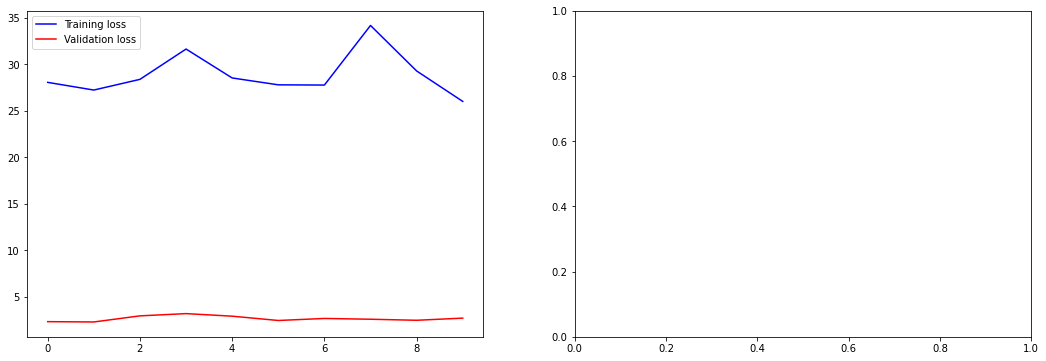

In [32]:
from matplotlib.pyplot import figure

# Plot the loss and mean absolute error from training and validation

plt.clf()

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(18, 6)

ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend()

ax[1].plot(history.history['mae'], color='b', label="Training mae")
ax[1].plot(history.history['val_mae'], color='r',label="Validation mae")
legend = ax[1].legend()

## Plot Actual Predictions

Use the model to predict placement for some random items in the validation set.

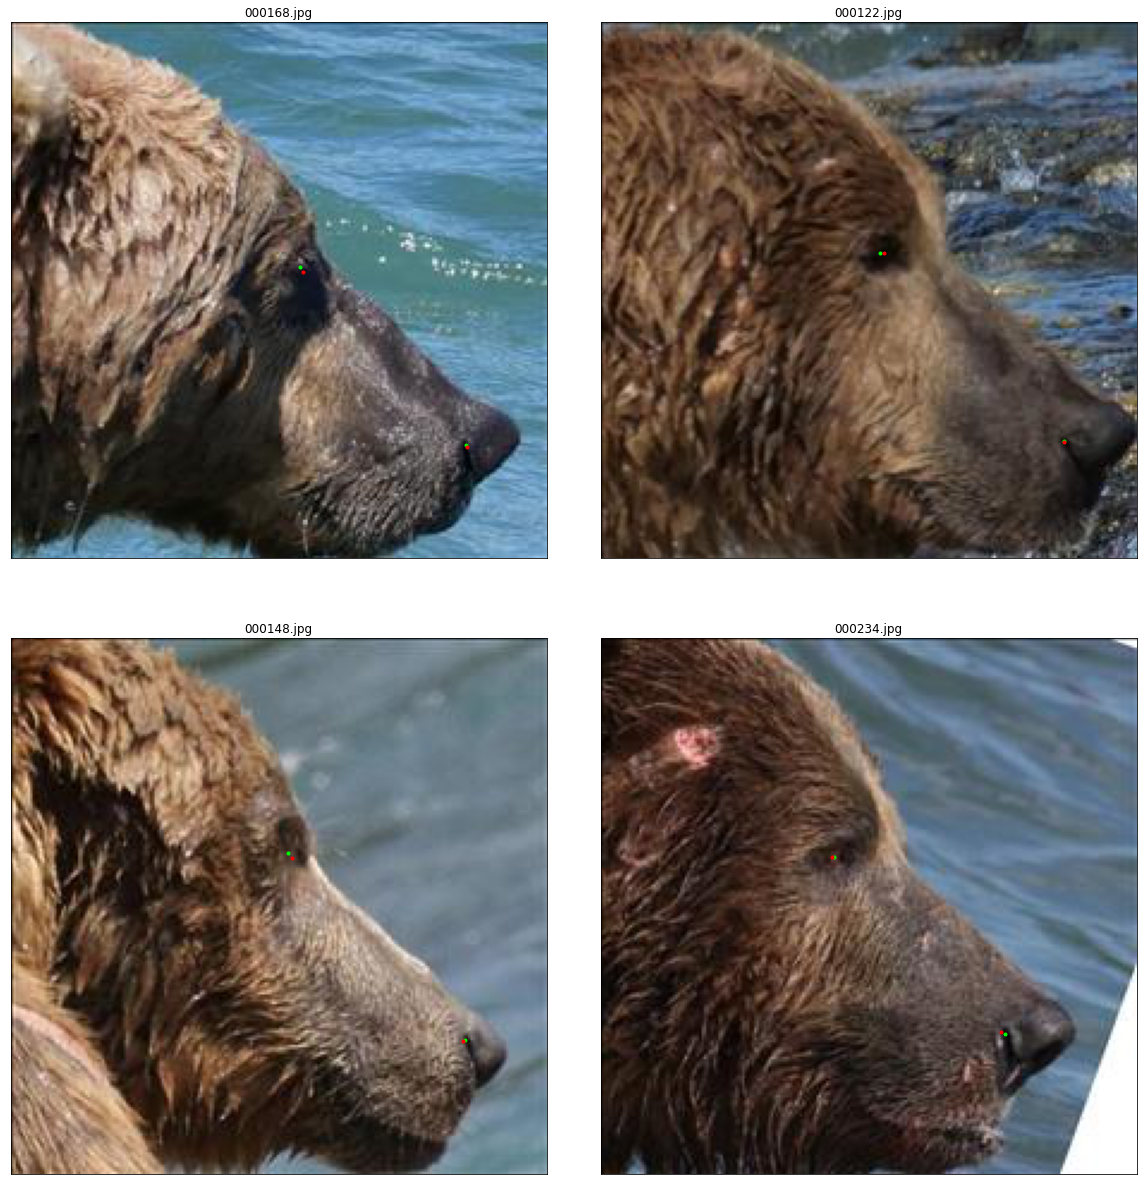

In [34]:
def plot_pred_pts(img_filename, pts):
    full_filename = os.path.join(image_directory, img_filename)
    image = cv2.imread(full_filename)
    #image = cv2.resize(image, (image_dim, image_dim), interpolation = cv2.INTER_CUBIC)
    
    if grayscale == True:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
    plt.imshow(image)
    # Preprocessing needed
    if preprocessing_needed == True:
        image = preprocess_input(image.astype(np.uint8)[None, :, :, :])
    else:
        image = image.astype(np.uint8)[None, :, :, :]
        image = image.astype(np.float32) / 255
        
    predictions = model.predict(image)
    
    if rescale_coordinates == True:
        #print(predictions)
        predictions = rescale_coordinates_up(predictions)

    for i in range(1, pts.shape[0], 2):
        plt.plot(pts[i-1], pts[i], marker='.', color='#00FF00')
        plt.plot(predictions[0][i-1], predictions[0][i], marker='.', color='#FF0000')
        #plt.plot(pts[i-1] * image_half_width + image_half_width, pts[i] * image_half_height + image_half_height, 'c.')
        #plt.plot(exp[i-1], exp[i], 'g.')
        
fig = plt.figure(figsize=(16, 16))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.15, wspace=0.05)

num_pred_images = 4

ax = type('', (), {})()
for i in range(num_pred_images):
    irandom_pic = np.random.choice(validation_data.shape[0])
    ax = fig.add_subplot(2, 2, i + 1, xticks=[], yticks=[])
    plot_pred_pts(validation_data[irandom_pic][0], validation_data[irandom_pic][1:])
    ax.set_title(validation_data[irandom_pic][0])
plt.show()

## Prune the Model

# Note there's probably something missing here, because the pruning does not result in a good model

Can skip this, but we're trying to prune the dense layers of the model to make it smaller.  This will make it less accurate, but hopefully only slightly so.

tensorflow_model_optimization install: https://www.tensorflow.org/model_optimization/guide/install

In [22]:
import tensorflow_model_optimization as tfmot

end_step = 12
# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

# Helper function uses `prune_low_magnitude` to make only the 
# Dense layers train with pruning.
def apply_pruning_to_dense(layer):
    global pruning_params
    
    if isinstance(layer, tf.keras.layers.Dense):
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    return layer

# Use `tf.keras.models.clone_model` to apply `apply_pruning_to_dense` 
# to the layers of the model.
model_for_pruning = tf.keras.models.clone_model(
    model,
    clone_function=apply_pruning_to_dense,
)

model_for_pruning.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
flatten_6 (Flatten)          (None, 100352)            0         
_________________________________________________________________
prune_low_magnitude_dense_12 (None, 512)               102760962 
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
prune_low_magnitude_dense_13 (None, 4)                 4102      
Total params: 126,329,864
Trainable params: 74,902,148
Non-trainable params: 51,427,716
_________________________________________________________________


In [24]:
import tempfile

logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train for 2 epochs
history = model_for_pruning.fit_generator(
                                generator=generator,
                                validation_data=validation_generator,
                                epochs=2,
                                validation_steps=1, # We set the batch_size to the whole validation set above, so just one validation step
                                callbacks=callbacks
                             )

Epoch 1/2
1/6 [====>.........................] - ETA: 0s - loss: 1894.4097 - mae: 41.6885WARNING:tensorflow:From C:\Users\adamr\Anaconda3\envs\tf\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
6/6 [==============================] - 42s 7s/step - loss: 1329.2069 - mae: 28.7178 - val_loss: 846.0096 - val_mae: 22.4137
Epoch 2/2
6/6 [==============================] - 41s 7s/step - loss: 213.6583 - mae: 10.5831 - val_loss: 10868.8975 - val_mae: 98.8738


## Export the Model To Tensorflow Lite format

First one saves the regular model:

In [35]:
#converter = tf.lite.TFLiteConverter.from_saved_model('bearskeypoint_20200731_1')
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Quantize the model - https://www.tensorflow.org/lite/guide/get_started#4_optimize_your_model_optional
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16] # Downgrade the weights from float32 to float16
tflite_quant_model = converter.convert()

open("resnetv2_noscale_flip_3.tflite", "wb").write(tflite_quant_model)

INFO:tensorflow:Assets written to: C:\Users\adamr\AppData\Local\Temp\tmpbelss4oj\assets


149871440

Second one saves the pruned model:

In [25]:
#converter = tf.lite.TFLiteConverter.from_saved_model('bearskeypoint_20200731_1')
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_pruning)

# Quantize the model - https://www.tensorflow.org/lite/guide/get_started#4_optimize_your_model_optional
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16] # Downgrade the weights from float32 to float16
tflite_quant_model = converter.convert()

open("resnetv2_noscale_flip_prune_2.tflite", "wb").write(tflite_quant_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\adamr\AppData\Local\Temp\tmpptm6i1f7\assets


ValueError: Input 0 of node sequential_6/prune_low_magnitude_dense_12/AssignVariableOp was passed float from sequential_6/prune_low_magnitude_dense_12/Mul/ReadVariableOp/resource:0 incompatible with expected resource.